In [1]:
#standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
! pip install pmdarima

**Final Project - Time Series Analysis :**

- Santosh Aditya Yarlagadda (say294)
- Harsha Gangasani (sg6423)


- In this project we look at two datasets
    - **CO2 concentration** | Data obtained from NOAA data repository
    - **COVID-19 Cases is USA** | Data obtained from NY times Git hub repository

# CO2 Concentration Analysis

## Data preprocessing

In [3]:
#getting data
data_co2 = pd.read_csv("CO2_concentration_noaa.csv")

#creating date using Year, Month and Day columns
data_co2["Date"] = pd.to_datetime(data_co2[["Year","Month","Day"]])

#setting Date as index
data_co2 = data_co2.set_index("Date")

#checking the data set
data_co2.head()

,Year,Month,Day,CO2 concentration (ppm)
Date,,,,
1974-05-19,1974,5,19,333.37
1974-05-26,1974,5,26,332.95
1974-06-02,1974,6,2,332.35
1974-06-09,1974,6,9,332.20
1974-06-16,1974,6,16,332.37


- The NaN values are represented by -999 in this data set. Let's find these values and impute them with the previous value

In [4]:
data_co2[data_co2["CO2 concentration (ppm)"]<0]

,Year,Month,Day,CO2 concentration (ppm)
Date,,,,
1975-10-05,1975,10,5,-999.99
1975-12-07,1975,12,7,-999.99
1975-12-14,1975,12,14,-999.99
1975-12-21,1975,12,21,-999.99
1975-12-28,1975,12,28,-999.99
1976-06-27,1976,6,27,-999.99
1982-03-21,1982,3,21,-999.99
1982-04-11,1982,4,11,-999.99
1982-04-18,1982,4,18,-999.99


In [5]:
#replacing -999.99 with NaN
data_co2 = data_co2.replace(to_replace = -999.99, value = np.nan)
#backfilling NaN values
data_co2 = data_co2.fillna(method="backfill")

## Train and Test split

In [6]:
print("Number of Observations in the CO2 Data Set : ",data_co2.shape[0])
print("The time series starts from : ",data_co2.index.min())
print("The time series ends at : ",data_co2.index.max())

Number of Observations in the CO2 Data Set :  2451
The time series starts from :  1974-05-19 00:00:00
The time series ends at :  2021-05-02 00:00:00


- Here we will use data till 2020 to fit our model and use data post that for our predictions

In [7]:
data_co2_train = data_co2[data_co2["Year"]<2020]
data_co2_test = data_co2[data_co2["Year"]>=2020]

print("No. of examples in training : ", data_co2_train.shape[0])
print("No. of examples for prediction : ", data_co2_test.shape[0])

No. of examples in training :  2381
No. of examples for prediction :  70


## Visualization
- Let's visualize the Data set and check if we can notice any trend and seasonality in the time series

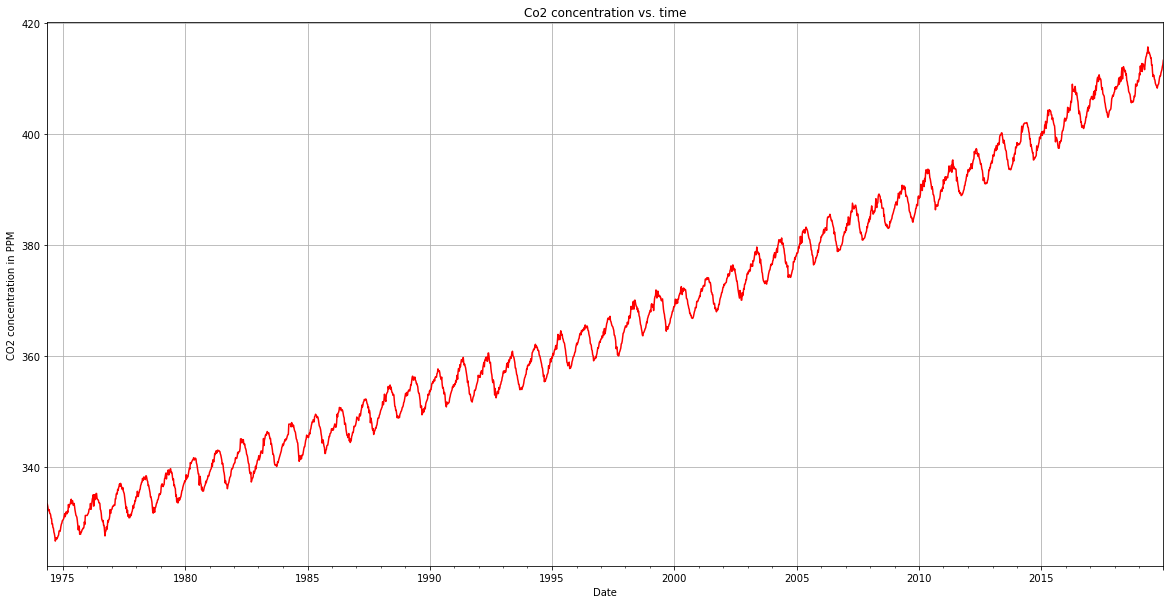

In [8]:
plt.figure(figsize=(20,10))
data_co2_train["CO2 concentration (ppm)"].plot(color="red")
plt.ylabel("CO2 concentration in PPM")
plt.title("Co2 concentration vs. time")
plt.grid()

- Now let's plot the data only for 2015(arbitary year for analysis) to observe seasonality and draw conclusions

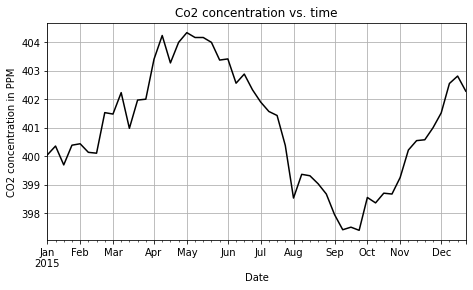

In [9]:
data_co2_train_2015 = data_co2_train[data_co2_train["Year"]==2015]
plt.figure(figsize=(7.5,4))
data_co2_train_2015["CO2 concentration (ppm)"].plot(color="black")
plt.ylabel("CO2 concentration in PPM")
plt.title("Co2 concentration vs. time")
plt.grid()

**Observations**
- From the above plots we can clearly see an increasing trend in the CO2 concentration
- There is also some seasonality in the data set. Looks like the CO2 concentration is highest during summer months and lowest during fall
- The values again in increase in the winter months, probably due to heating requirements
- These observations confirm that the data is **not stationary**


**Next Steps**
- We need to make our data set stationary for Time Series modelling
- We hope to achieve this by removing seasonality and trend 

## Detrending
- Here will use three different detrending methods
    - Detrend by Differencing
    - Detrend by Linear Regression
    - Detrend by Linear Regression using Polynomial Features

## Detrending by Differencing

- Here we employ differencing methods to remove the trend. 
- This method ideally should work well, given the linear nature of the trend in our time series

In [10]:
#creating a column for First Difference
data_co2_train["CO2_diff1"] = 0

for i in range(1,data_co2_train.shape[0]):
    data_co2_train.iloc[i,4] = data_co2_train.iloc[i,3] - data_co2_train.iloc[i-1,3]

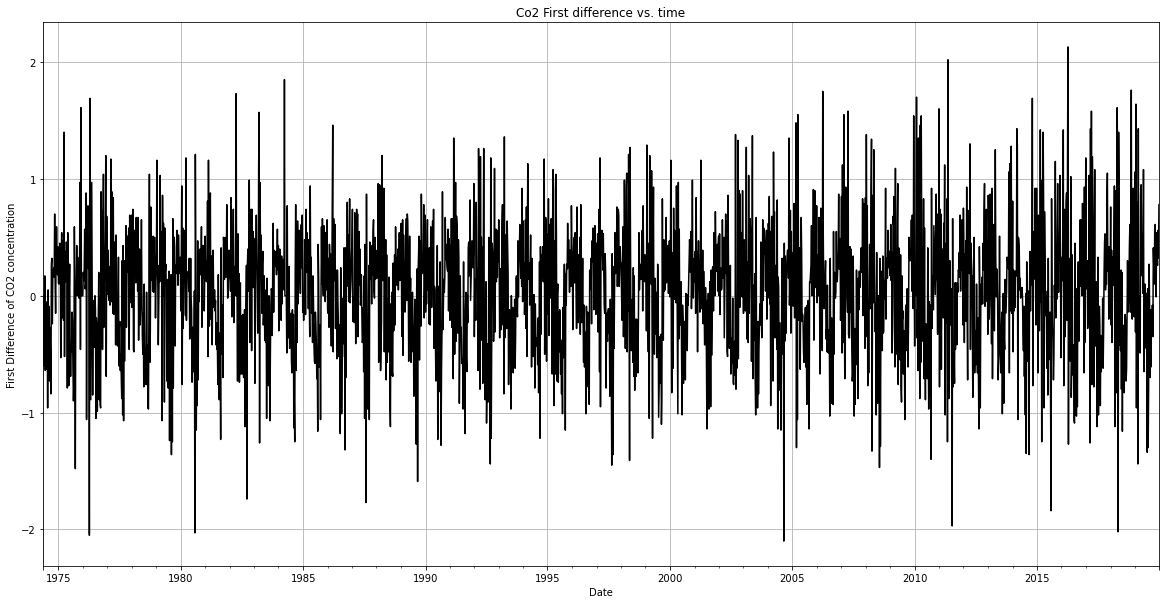

In [11]:
#plotting the first difference of CO2 concentration
plt.figure(figsize=(20,10))
data_co2_train["CO2_diff1"].plot(color="black")
plt.ylabel("First Difference of CO2 concentration")
plt.title("Co2 First difference vs. time")
plt.grid()

**Observations**
- Looks like the differencing method was succesful in detrending the time series
- We still see a seasonal pattern in our data. We will explore removing seasonality in the further sections

### Detrending by Linear Regression (Model fitting)
- As we observed that the trend in our time series is linear, we can try to model it using a Linear Regression and remove it to detrend

In [12]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression()

#creating an array for time index
X_time = [i for i in range(0,data_co2_train.shape[0])]
X_time = np.reshape(X_time,(len(X_time),1))

#fitting the model
model_LR.fit(X_time,data_co2_train["CO2 concentration (ppm)"])

#predicting
data_co2_train["CO2_LR_pred"] = model_LR.predict(X_time)

#Removing the Linear trend
data_co2_train["CO2 - Linear Trend"] = data_co2_train["CO2 concentration (ppm)"] - data_co2_train["CO2_LR_pred"]

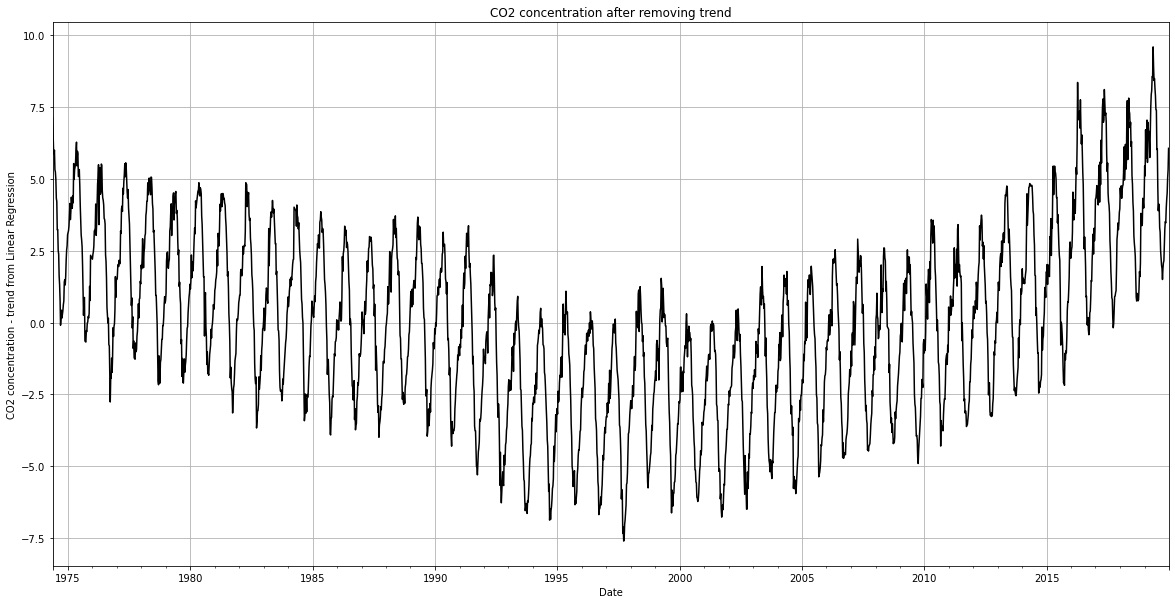

In [13]:
#plotting the CO2 concentration after removing trend using Linear Regression
plt.figure(figsize=(20,10))
data_co2_train["CO2 - Linear Trend"].plot(color="black")
plt.ylabel("CO2 concentration - trend from Linear Regression")
plt.title("CO2 concentration after removing trend")
plt.grid()

**Observations**
- By modelling the trend using Linear Regression and subtracting from the timeseries, we acheive the above graph
- This method definetely removed a major component of the trend. 
- We still observe seasonality.
- The data has an unsual dip in the centre. Looks like differencing performed better than the linear regression detrending

### Detrending by Polynomial Regression (Model fitting)
- Now we will try to model the trend as a quadaratic polynomial
- We will acheive this by creating polynomial features and regressing them on time

In [14]:
from sklearn.preprocessing import PolynomialFeatures

#creating quadratic features
poly_feat = PolynomialFeatures(degree=2)

#tranforming X_time
X_time = poly_feat.fit_transform(X_time)

#new linear regression
model_poly = LinearRegression()

#fitting the model
model_poly.fit(X_time,data_co2_train["CO2 concentration (ppm)"])

#predicting
data_co2_train["CO2_poly_pred"] = model_poly.predict(X_time)

#Removing the Linear trend
data_co2_train["CO2 - Polynomial(2) Trend"] = data_co2_train["CO2 concentration (ppm)"] - data_co2_train["CO2_poly_pred"]

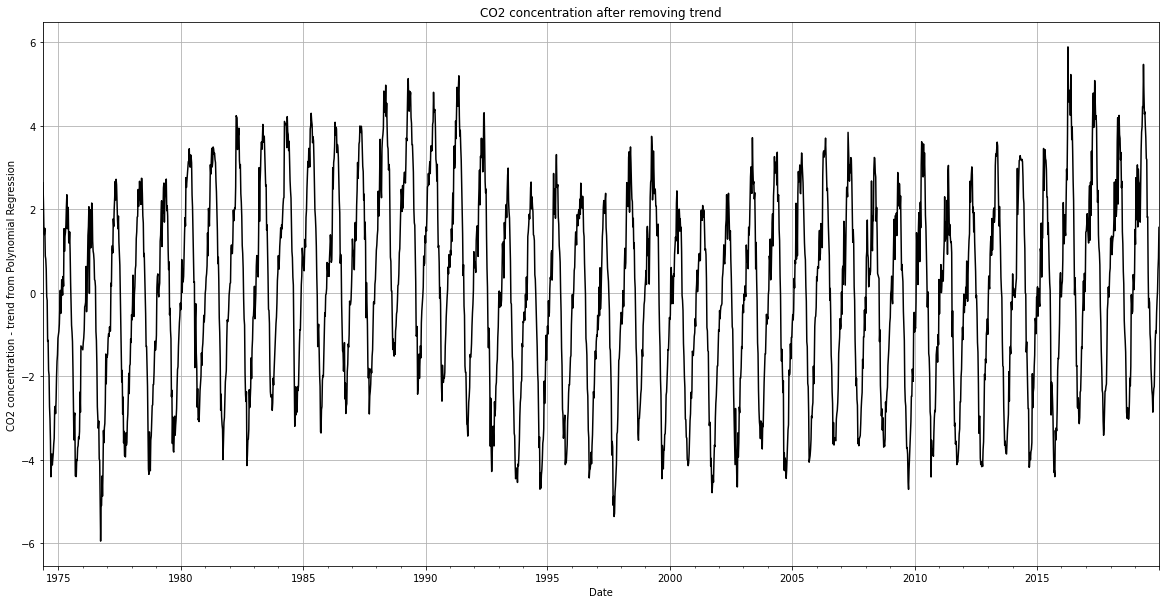

In [15]:
#plotting the CO2 concentration after removing trend using Linear Regression
plt.figure(figsize=(20,10))
data_co2_train["CO2 - Polynomial(2) Trend"].plot(color="black")
plt.ylabel("CO2 concentration - trend from Polynomial Regression")
plt.title("CO2 concentration after removing trend")
plt.grid()

**Observations:**

- Looks like detrending using polynomial features was succesful in removing the trend component in the time series
- We notice that the regression with polynomial features was able to capture the trend pattern better than simple Linear Regression

## Deseasonalizing
- In this section we explore two different way to remove the seasonality
    - Using Python's seasonal decompose package
    - Using Seasonal Index 


### Deseasonalizing with seasonal_decompose

- In order to remove the seasonality we can employ seasonal_decompose from statsmodel library in python to model trend and seasonality
- The out put gives individual series for trend, seasonality and residuals
- We use an additive model for the decomposition => Time series = Trend + Seasonality + Residuals

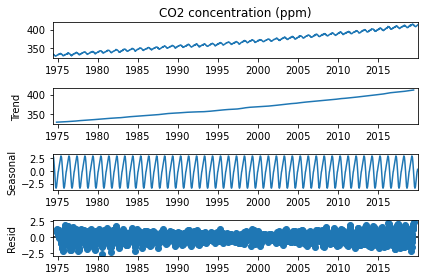

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
data_co2_decomp = seasonal_decompose(data_co2_train["CO2 concentration (ppm)"],model="additive")
data_co2_decomp.plot()
plt.show()

- The seasonal_decompose utility was able to split the our time series into three components
- One problem we face with this approach is lack of tractability, which is an issue when we need to retrend and reseasonalise the data from our predictions

### Deseasonalizing with Seasonal Index

- One other way to remove the seasonality effect is to normalize the data with Seasonal Indices
- Seasonal index = period average/total average
- Deaseasonalized value =  actual value/seasonal index

This method has been adapted from : http://business.unr.edu/faculty/ronlembke/handouts/Seasonality%20Final17.pdf

In [17]:
#calculating seasonal index
df = data_co2_train["CO2 concentration (ppm)"]
deseason = df.groupby(df.index.month).mean()
deseason = deseason/df.mean()

#converting deseason to data frame for flexibility
seasonal_index = pd.DataFrame(deseason)
seasonal_index = seasonal_index.rename(columns={"CO2 concentration (ppm)":"Seasonal Index"})
seasonal_index.index.names = ['Month']
seasonal_index

,Seasonal Index
Month,
1,0.999604
2,1.001404
3,1.004614
4,1.008307
5,1.007639
6,1.004889
7,1.001022
8,0.994206
9,0.991527


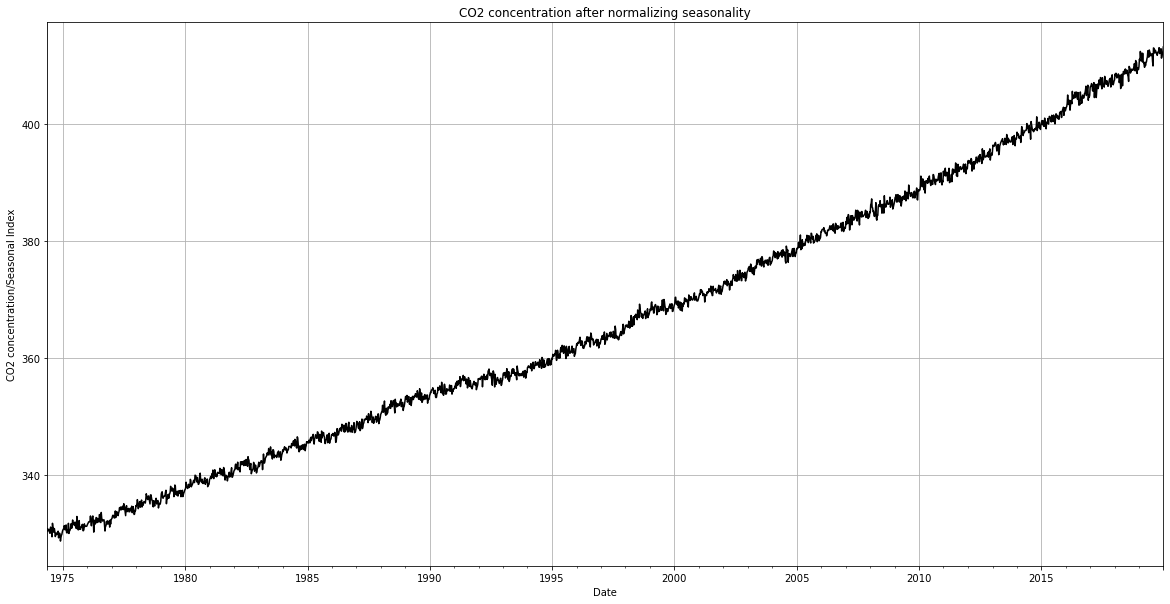

In [18]:
#merging the data with Seasonal averages
data_co2_train = data_co2_train.reset_index().merge(seasonal_index,on="Month",sort=False).set_index(data_co2_train.index.names)

#sorting the resultant data frame
data_co2_train = data_co2_train.sort_index()

#normalizing the CO2 concentrating values by dividing them with seasonal averages
data_co2_train["seasonality_normalized"] = 0
data_co2_train["seasonality_normalized"] = data_co2_train["CO2 concentration (ppm)"]/ data_co2_train["Seasonal Index"]

#plotting the CO2 concentration after removing trend using Linear Regression
plt.figure(figsize=(20,10))
data_co2_train["seasonality_normalized"].plot(color="black")
plt.ylabel("CO2 concentration/Seasonal Index")
plt.title("CO2 concentration after normalizing seasonality")
plt.grid()


- Again let's look at one year data (2015) to investigate the efficacy of our deseasonalizing

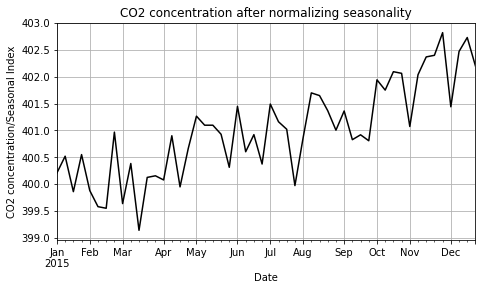

In [19]:
data_co2_train_2015 = data_co2_train[data_co2_train["Year"]==2015]
plt.figure(figsize=(7.5,4))
data_co2_train_2015["seasonality_normalized"].plot(color="black")
plt.ylabel("CO2 concentration/Seasonal Index")
plt.title("CO2 concentration after normalizing seasonality")
plt.grid()

**Observations**
- Comparing these plots to our intial visualization, we can see that our time series doesn't exhibit high degree of seasonality anymore

## Testing for stationarity
- In this section we will use of some of the techniques from the previous section to remove trend and seasonailty from our data
- Later we employ Augmented Dickey Fuller test to check for stationarity
    - **Null Hypothesis** : The series is not stationary
    - **Alternate Hypothesis** : The time series is stationary
    - We will use 0.05 as our critical p value. If the p value from our test is <=0.05, we can reject the Null Hypothesis in favour of the Alternate hypothesis
    
We will test two combinations of decompositions below and select the best one based on ADF test results

## Decomposition 1

- The seasonality will be removed by normalizing the CO2 concentration with seasonal indices
- We will remove the trend using a regression with polynomial features

In [20]:
#getting the seasonality_normalized data from previous section
data_CO2_model = data_co2_train[["seasonality_normalized","CO2 concentration (ppm)","Seasonal Index"]]

In [21]:
#creating quadratic features
poly_feat = PolynomialFeatures(degree=2)

#Creating polynomial features
X_time = [i for i in range(0,data_co2_train.shape[0])]
X_time = np.reshape(X_time,(len(X_time),1))
X_time = poly_feat.fit_transform(X_time)

#new linear regression
model_poly = LinearRegression()

#fitting the model
model_poly.fit(X_time,data_CO2_model["seasonality_normalized"])

#predicting
data_CO2_model["CO2_norm_polytrend"] = model_poly.predict(X_time)

#Removing the Linear trend
data_CO2_model["CO2_norm - Polynomial(2) Trend"] = data_CO2_model["seasonality_normalized"] - data_CO2_model["CO2_norm_polytrend"]

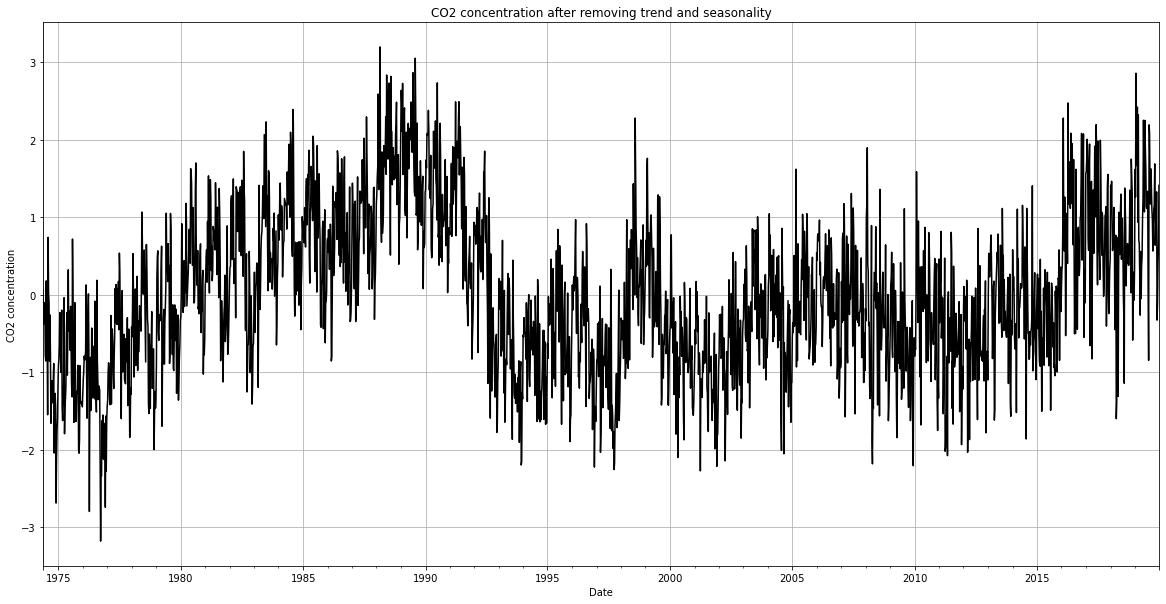

In [22]:
#plotting the CO2 concentration after removing trend using Linear Regression
plt.figure(figsize=(20,10))
data_CO2_model["CO2_norm - Polynomial(2) Trend"].plot(color="black")
plt.ylabel("CO2 concentration")
plt.title("CO2 concentration after removing trend and seasonality")
plt.grid()

In [23]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_CO2_model["CO2_norm - Polynomial(2) Trend"])
print("The test statastic :",result[0])
print("The p-value:", result[1])
print("No. of Lags used:", result[2])
print("Critical Values:", result[4])

The test statastic : -3.5926235199060663
The p-value: 0.005903626268352628
No. of Lags used: 27
Critical Values: {'1%': -3.433132170938598, '5%': -2.8627691145928087, '10%': -2.567424311005166}


- Based on the p value, we can confirm that our data is stationary

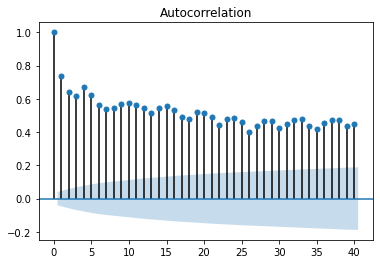

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
num_lags = 40
#plotting ACF
acf_values = plot_acf(data_CO2_model["CO2_norm - Polynomial(2) Trend"], lags=num_lags, zero = True)

- The Auto correlation function although decreasing, but doesn't tailoff until large number of lags
- This increases the complexity of our model by adding large number of terms

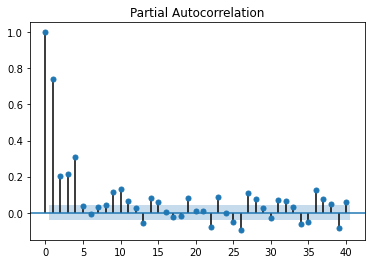

In [25]:
#plotting PACF
pacf_values = plot_pacf(data_CO2_model["CO2_norm - Polynomial(2) Trend"], lags=40, zero = True)

- We have significant values for lags 0,1,2,3,4. But the PACF still requires high number of lags to tail off

## Decomposition 2
- Instead of modelling the trend, we use differencing here to remove the trend component
- We will still use the Seasonal Index method for removing seasonality

In [26]:
#getting the seasonality_normalized data from previous section
data_CO2_model = data_co2_train[["seasonality_normalized","CO2 concentration (ppm)","Seasonal Index"]]

#creating a column for First Difference
data_CO2_model["seasonality_normalized_diff"] = 0

for i in range(1,data_CO2_model.shape[0]):
    data_CO2_model.iloc[i,3] = data_CO2_model.iloc[i,0] - data_CO2_model.iloc[i-1,0]
    
data_CO2_model = data_CO2_model.iloc[1:,:]

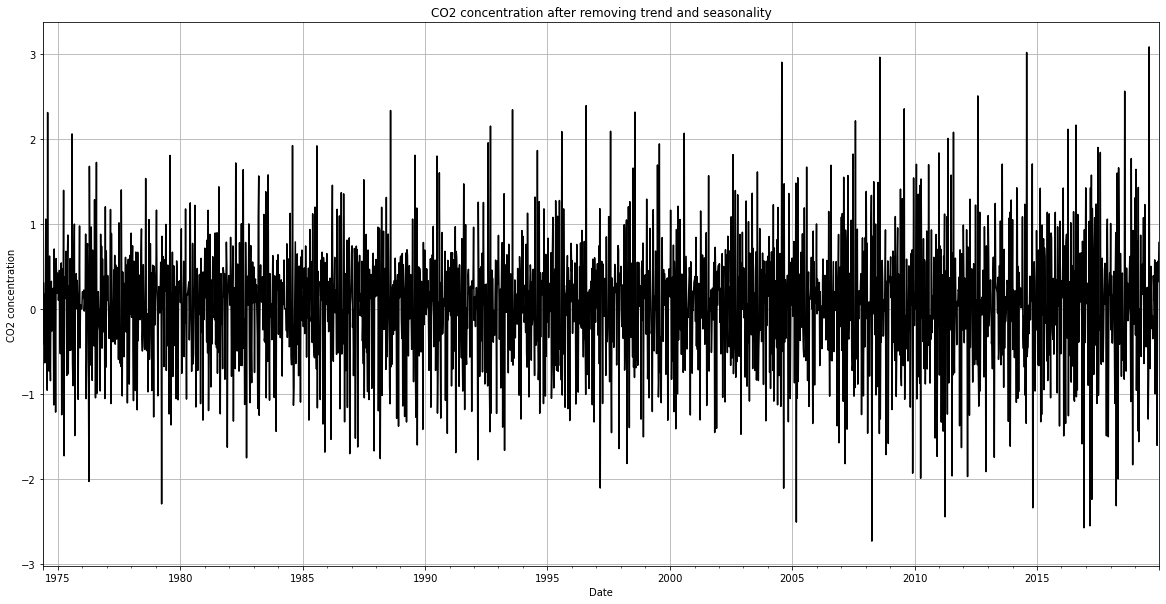

In [27]:
#plotting the CO2 concentration after removing trend using Linear Regression
plt.figure(figsize=(20,10))
data_CO2_model["seasonality_normalized_diff"].plot(color="black")
plt.ylabel("CO2 concentration")
plt.title("CO2 concentration after removing trend and seasonality")
plt.grid()

In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_CO2_model["seasonality_normalized_diff"])
print("The test statastic :",result[0])
print("The p-value:", result[1])
print("No. of Lags used:", result[2])
print("Critical Values:", result[4])

The test statastic : -12.831085131046596
The p-value: 5.871656598984262e-24
No. of Lags used: 26
Critical Values: {'1%': -3.433132170938598, '5%': -2.8627691145928087, '10%': -2.567424311005166}


- The extremely low p value, suggests strong stationarity
- We notice that differencing produces better results than polynomial estimation of the trend

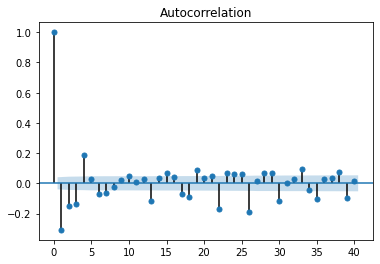

In [29]:
num_lags = 40
#plotting ACF
acf_values = plot_acf(data_CO2_model["seasonality_normalized_diff"], lags=num_lags, zero = True)

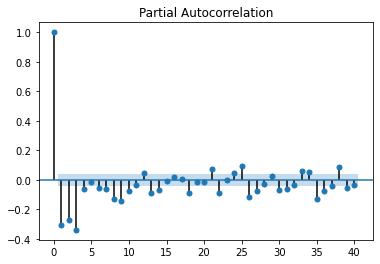

In [30]:
#plotting PACF
pacf_values = plot_pacf(data_CO2_model["seasonality_normalized_diff"], lags=num_lags, zero = True)

**Observations**
- The ACF and PACF functions with this method have a better profile
- From PACF, we can see that the values are significant till lag 4. This suggests p = 4 for the AR portion 
- From ACF, we can see that the valuess are significant till lag 4. This suggests q = 4 for the MA portion

**Next Steps**
- We can see that the decomposition 2 was able to acheive a more stationary time series
- So for our modelling we use the resultant time series from decomposition 2

## Modelling
- In order to model our time series we fit an ARIMA model.
- To make the model more robust we utilize Python's auto-arima model which runs multiple arima models and pick the best one based on a criteria.
- Here we use Akaike Information Criterion to pick our best model
- AIC : 2k - 2ln(L)
    - k	=	number of estimated parameters in the model
    - L	=	maximum value of the likelihood function for the model

In [31]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(y=data_CO2_model["seasonality_normalized_diff"],start_p=0, start_q = 0,max_p = 10, max_q=10)
arima_model.summary()

predictions = arima_model.predict_in_sample()

In [32]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2380
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -2191.915
Date:                Thu, 20 May 2021   AIC                           4397.831
Time:                        12:41:55   BIC                           4438.255
Sample:                             0   HQIC                          4412.543
                               - 2380                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0134      0.002      7.866      0.000       0.010       0.017
ar.L1          0.3926      0.024     16.424      0.000       0.346       0.439
ar.L2          0.0011      0.025      0.046      0.963      -0.048       0.050
ar.L3         -0.0090      0.025     -0.358      0.720      -0.058       0.040
ar.L4          0.2290      0.023     10.119      0.000       0.185       0.273
ma.L1         -0.9463      0.012    -77.587      0.000      -0.970      -0.922
sigma2         0.3692      0.010     37.727      0.000       0.350       0.388
===================================================================================
Ljung-Box (Q):                      224.21   Jarque-Bera (JB):                30.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residual Analysis

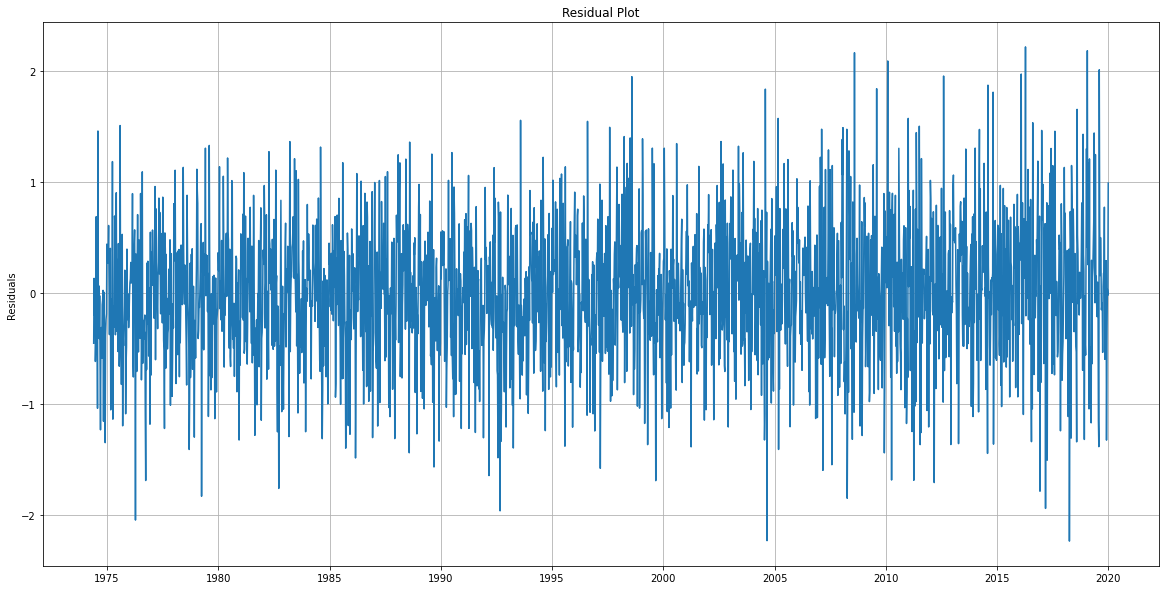

In [33]:
#plotting the residuals
residuals = data_CO2_model["seasonality_normalized_diff"] - predictions
plt.figure(figsize=(20,10))
plt.plot(data_CO2_model.index,residuals)
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid()


- Looks like our residuals are centered at zero. They do not show any significant trend or seasonality
- This suggests that the model was able to capture all the structured components for our data
- Now let's find the summary statastics for the residuals to confirm that mean is actually centered at zero

In [34]:
#summary statastics for residuals
residuals_df = pd.DataFrame(residuals)
residuals_df.describe()

,seasonality_normalized_diff
count,2380.000000
mean,-0.001318
std,0.607819
min,-2.234621
25%,-0.366548
50%,0.005461
75%,0.376396
max,2.219383


- From the above results we can confirm that the residuals are indeed centered at 0
- Now let's look at the distribution of the residuals. Ideally we want them to follow a normal distribution. A historgram plot can help us investigate this

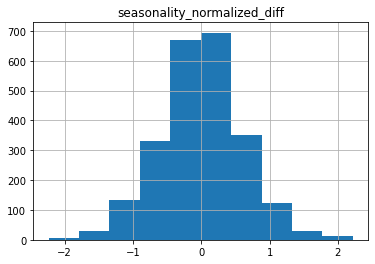

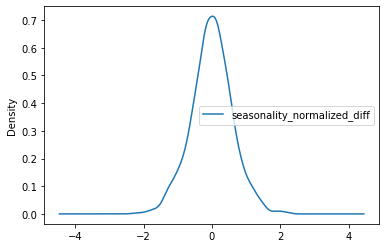

In [35]:
#plotting Historgrams
residuals_df.hist()
#plotting kde
residuals_df.plot(kind="kde")

- We can see that the distribution of residuals resemble a normal distribution
- They do not exhibit any significant skewness
- The distribution very light tails, suggesting a kurtosis less than 3

- Lets compare our residuals distribution to a standard normal distribution by plotting Q-Q plot

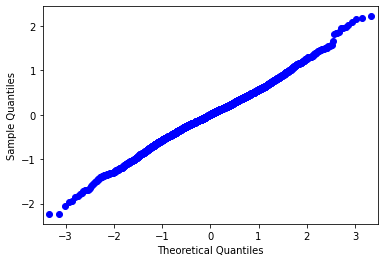

In [36]:
from statsmodels.graphics.gofplots import qqplot
qplot = qqplot(residuals_df["seasonality_normalized_diff"])

- The above graphs suggest that are residuals distribution is very similar to normal distribution.
- We see deviations at higher quantiles. This confirms our intial hypothesis of the distribution being leptokurtic

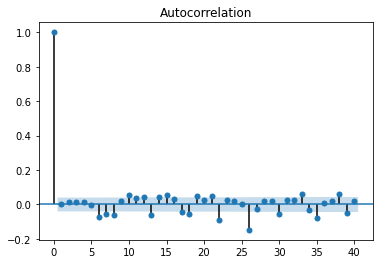

In [37]:
from pandas.plotting import autocorrelation_plot
acf_values_res = plot_acf(residuals, lags=40, zero = True)

- We have significant auto correlation only for lag 0. This suggests that the residuals are only correlated with it self and are independent of others
- Based on the residual analysis, we can conlude the model is able to capture the patterns in our time series

## In-Sample predictions
- We need to convert our predictions into the original scale to visualize the quality of our predictions
- For this we need to undo the differencing
- We also reseasonalize our data. We acheive this by multiplying our results after undoing referencing with Seasonal Index

In [38]:
#reversing differencing
data_CO2_model["predictions_deseasonalized_diff"] = predictions #adding predictions to the data fram
data_CO2_model["CO2_predictions"] = 0 #creating a zero column for storing predictions
data_CO2_model.iloc[0,5] = None

for i in range(1, data_CO2_model.shape[0]):
    data_CO2_model.iloc[i,5] = data_CO2_model.iloc[i,4] + data_CO2_model.iloc[i-1,0] #reversing the differencing
    data_CO2_model.iloc[i,5] = data_CO2_model.iloc[i,5]*data_CO2_model.iloc[i,2] #reseasonalizing

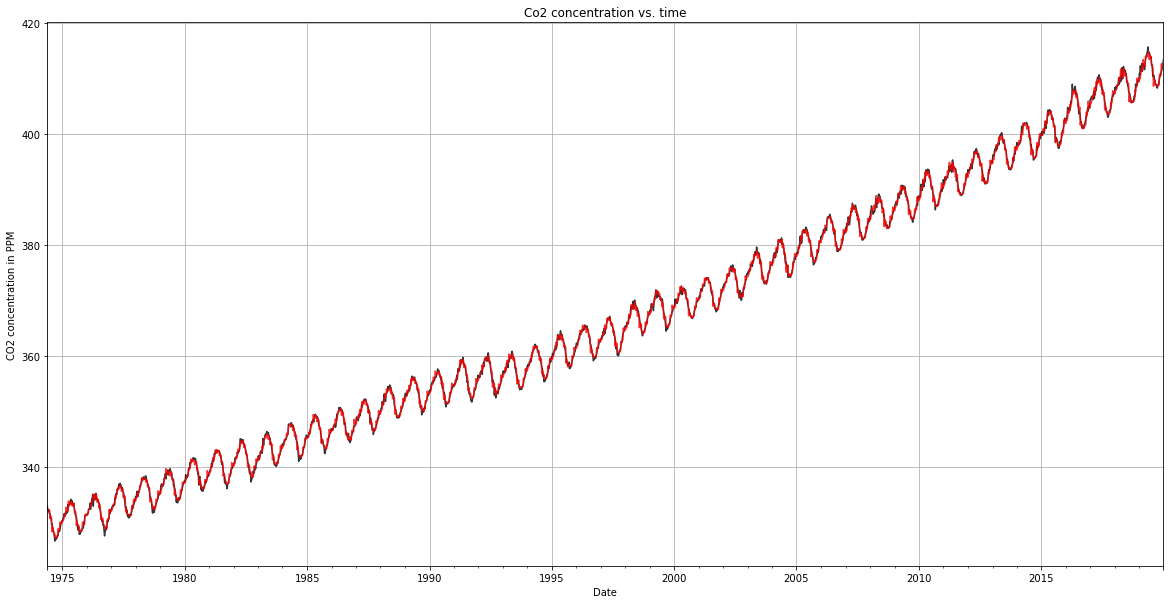

In [39]:
plt.figure(figsize=(20,10))
data_CO2_model["CO2 concentration (ppm)"].plot(color="black",alpha=0.8)
# df3.plot(color="red")
data_CO2_model["CO2_predictions"].plot(color="red",alpha =0.8)
plt.ylabel("CO2 concentration in PPM")
plt.title("Co2 concentration vs. time")
plt.grid()

- As we can see we were able to capture the patterns in time series well
- Next we move to testing our model on out of sample data set

## Forecasting
- In this section we will use our model to forecast the CO2 concentration for 2020 Jan - 2021 May

In [40]:
print("No. of examples to forecast : ", data_co2_test.shape[0])

No. of examples to forecast :  70


In [41]:
#Adding the seasonal index created to our test data set
data_co2_test = data_co2_test.reset_index().merge(seasonal_index,on="Month",sort=False).set_index(data_co2_test.index.names)

In [42]:
forecast = arima_model.predict(n_periods=70)# predicting 70 periods into the future
data_co2_test["predictions_deseasonalized_diff"] = forecast

In [43]:
#transforming the date into original scale
data_co2_test["CO2_test_predictions"] = data_co2_test["predictions_deseasonalized_diff"] #creating a zero column for storing predictions
data_co2_test.iloc[0,6] = 413.60 #assigning the first value for our predictions

#reversing the differencing
data_co2_test["CO2_test_predictions"] = data_co2_test["CO2_test_predictions"].cumsum()
#reseasonalizing
data_co2_test["CO2_test_predictions"] = data_co2_test["CO2_test_predictions"]*data_co2_test["Seasonal Index"]

data_co2_test.head()

,Year,Month,Day,CO2 concentration (ppm),Seasonal Index,predictions_deseasonalized_diff,CO2_test_predictions
Date,,,,,,,
2020-01-05,2020,1,5,413.60,0.999604,-0.564335,413.436275
2020-01-12,2020,1,12,413.02,0.999604,-0.081940,413.354368
2020-01-19,2020,1,19,413.87,0.999604,0.046806,413.401156
2020-01-26,2020,1,26,414.26,0.999604,0.215345,413.616415
2021-01-03,2021,1,3,415.38,0.999604,-0.030542,413.585885


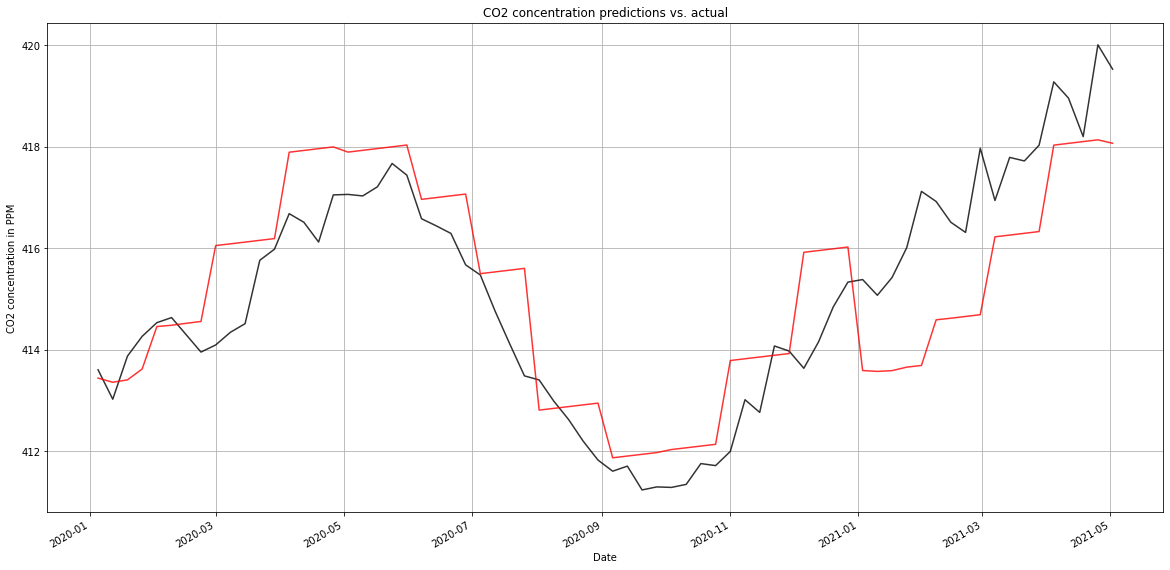

In [44]:
plt.figure(figsize=(20,10))
data_co2_test["CO2 concentration (ppm)"].plot(color="black",alpha=0.8)
# df3.plot(color="red")
data_co2_test["CO2_test_predictions"].plot(color="red",alpha =0.8)
plt.ylabel("CO2 concentration in PPM")
plt.title("CO2 concentration predictions vs. actual")
plt.grid()

- Looks  like our model is able to come up with decent predictions for the test data set
- We were able to capture the trend and seasonality components in the time series

# Covid Cases in the U.S.
- In this section we try to model the COVID-19 cases in the US
- The data has been obtained from NY times Git Hub repository
- This analysis is to demonstrate time series on a different kind of dataset. The analysis here is not as exhaustive as the previous case.

In [45]:
data_covid = pd.read_csv("US_Covid_daily.csv", parse_dates=["date"],index_col="date")
print("Number of observations : ",data_covid.shape[0])
print("The time series starts from : ",data_covid.index.min())
print("The time series ends at : ",data_covid.index.max())
data_covid.head()

Number of observations :  477
The time series starts from :  2020-01-21 00:00:00
The time series ends at :  2021-05-11 00:00:00


,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


- As a part of our analysis we are interested in the daily increase in case count rather the cumulative case count
- This approach has two benefits
    - Identifying the new cases gives authorities a chance to create an action plan
    - This is indirectly applying first differencing, which might help in making the data stationary

In [46]:
#calculating the daily increase in covid-19 cases
data_covid["Daily_increase_in_cases"] = data_covid["cases"].diff()
#calculating the daily increase in covid-19 deaths
data_covid["Daily_increase_in_deaths"] = data_covid["deaths"].diff()

- Let's visualize the data

Text(0.5, 1.0, 'Total number of cases recorded')

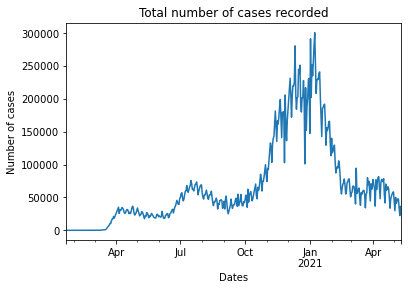

In [47]:
#plotting the data set
data_covid["Daily_increase_in_cases"].plot()
plt.xlabel("Dates")
plt.ylabel("Number of cases")
plt.title("Total number of cases recorded")

- From the above visualization, we can see that our data is not stationary
- The mean for our time series is not constant and we can also notice changes in the variance

## Detrending by differencing
- Considering our Time Series data is not stationary, we will try to calculate the differences of the increase in the hope that the resultant series is stationary

Text(0.5, 1.0, 'Total number of cases recorded')

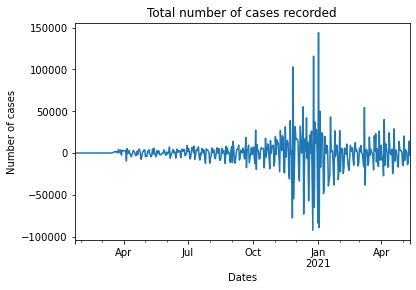

In [48]:
data_covid["Difference_cases_increase"] = data_covid["Daily_increase_in_cases"].diff()
data_covid = data_covid.iloc[2:,:] #removing the NaN values
#plotting the data set
data_covid["Difference_cases_increase"].plot()
plt.xlabel("Dates")
plt.ylabel("Number of cases")
plt.title("Total number of cases recorded")

- Now our data set is centered around 0, suggesting a common mean of 0.
- The variance increases towards the end of 2020, with high variations recorded in the first two months of 2021

## Testing for stationarity
- We will perform the Dickey-Fuller test to check for stationarity
    - Null Hypothesis : The series is not stationary
    - Alternate Hypothesis : the time series is stationary
    - We will use 0.05 as our critical p value. If the p value from our test is <=0.05, we can reject the Null Hypothesis in favour of the Alternat Hypothesis


In [49]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_covid["Difference_cases_increase"])
print("The test statastic :",result[0])
print("The p-value:", result[1])
print("No. of Lags used:", result[2])
print("Critical Values:", result[4])

The test statastic : -6.108270473885543
The p-value: 9.468226516902959e-08
No. of Lags used: 13
Critical Values: {'1%': -3.4446148284445153, '5%': -2.8678299626609314, '10%': -2.5701203107928157}


- Our test statastic is ~-6 which is lower than -3.44. Hence we can reject the Null_hypothesis in favour of the Alternate with a significance level lower than 1%
- We can conclude that the time series is now stationary

## Plotting ACF and PACF 
- In this section we will find out the ACF and PACF, which will give us some insight into the model selection


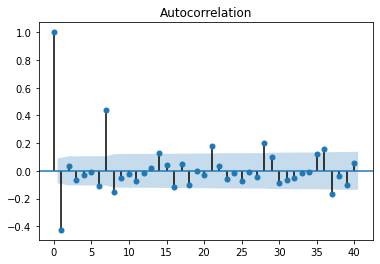

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
num_lags = 40
acf_values = plot_acf(data_covid["Difference_cases_increase"], lags=num_lags, zero = True)

- We can see that Lag1 and Lag7 have the highest ACF

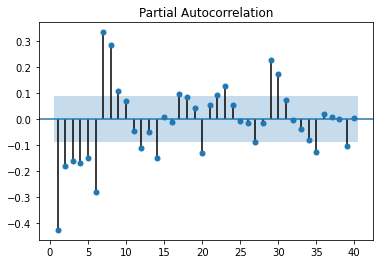

In [51]:
pacf_values = plot_pacf(data_covid["Difference_cases_increase"], lags=num_lags, zero = False)

- We can see high PACF till Lag 7

## Modelling and visualization
- Here we use Auto-arima again which will select the best model based on AIC(default)

In [52]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(y=data_covid["Difference_cases_increase"],start_p=0, start_q = 0,max_p = 10, max_q=10)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  475
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5272.370
Date:                Thu, 20 May 2021   AIC                          10552.739
Time:                        12:42:28   BIC                          10569.393
Sample:                             0   HQIC                         10559.288
                                - 475                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9052      0.035    -25.946      0.000      -0.974      -0.837
ma.L1          0.3452      0.036      9.718      0.000       0.276       0.415
ma.L2         -0.5759      0.023    -25.093      0.000      -0.621      -0.531
sigma2      2.556e+08   3.29e-11   7.77e+18      0.000    2.56e+08    2.56e+08
===================================================================================
Ljung-Box (Q):                      441.44   Jarque-Bera (JB):              1826.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              59.78   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.77e+35. Standard errors may be unstable.
"""

- From the above results we can see the the best model is ARIMA(1,0,2) | ARMA(1,2)

In [53]:
#predicting in sample data
predictions = arima_model.predict_in_sample()

- These predictions are for the first difference of covid increase, i.e., we predicted the increase in the daily covid increase time series. In the below section we reverse the differencing for visualization

In [54]:
#reversing the differencing
data_covid["predictions"] = predictions
data_covid["Predicted_increase"] = 0;

for i in range(1,data_covid.shape[0]):
    data_covid.iloc[i,6] = data_covid.iloc[i,5] + data_covid.iloc[i-1,2]

Text(0.5, 1.0, 'Increase in cases per day')

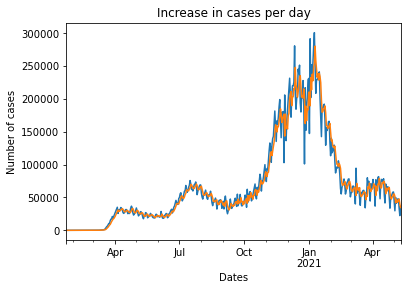

In [55]:
#plotting results
data_covid["Daily_increase_in_cases"].plot()
data_covid["Predicted_increase"].plot()
plt.xlabel("Dates")
plt.ylabel("Number of cases")
plt.title("Increase in cases per day")